# Confidence Intervals and Bootstrapping

Before we do anything, we will need to load some libraries

In [4]:
library(mosaicData)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Confidence Intervals

A confidence interval for an estimator $\theta$ uses the Central Limit Theorem and the sampling distribution to give an error for our estimator. 

In order to demonstrate this idea, I am going to use wage data from the City of Seattle. I am using this data set because it is complete population data rather than a sample and that means we can verify our confidence interval. However, for most of this lab I will be pretending that we don't know the population characteristics. This is closer to what you would be doing in the real world.

In [7]:
sea_wage_link<-"https://data.seattle.gov/api/views/2khk-5ukd/rows.csv?accessType=DOWNLOAD"
sea_wage <- read_csv(sea_wage_link)


── Column specification ────────────────────────────────────────────────────────
cols(
  Department = col_character(),
  `Last Name` = col_character(),
  `First Name` = col_character(),
  `Job Title` = col_character(),
  `Hourly Rate` = col_double()
)




### Large Sample and Z-distribution

In order to illustrate the idea of confidence intervals, let's say that we didn't have data about every City of Seattle employee. Let's say that we only had data on 100 employees.

In [4]:
sea_wage_sample<-sample_n(sea_wage,
                              100,
                              replace=FALSE)

Let's check the variable names in this set.

In [8]:
str(sea_wage_sample)

tibble [100 × 5] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Department : chr [1:100] "Seattle City Light" "Seattle City Light" "Finance & Admin Services" "Police Department" ...
 $ Last Name  : chr [1:100] "Chapman" "Wu" "Rumpf" "Svedin" ...
 $ First Name : chr [1:100] "Walter" "Qi" "Eric" "Louis" ...
 $ Job Title  : chr [1:100] "Lnwkr" "Elecl Engr,Asst I" "Manager3,Exempt" "Pol Ofcr- Student" ...
 $ Hourly Rate: num [1:100] 52.8 39.5 68 43 34.7 ...
 - attr(*, "spec")=
  .. cols(
  ..   Department = col_character(),
  ..   `Last Name` = col_character(),
  ..   `First Name` = col_character(),
  ..   `Job Title` = col_character(),
  ..   `Hourly Rate` = col_double()
  .. )


As we can see this data set only has 100 observations as opposed to the full data set which has 11,616. We will be most interested in the `Hourly Rate` variable.

Calculating the average salary of the sample gives us 

In [10]:
wage_mean_sample<-mean(sea_wage_sample$`Hourly Rate`)
wage_mean_sample

[1] 44.66369

Now the question arises as to how close our sample mean above is to the actual mean. Well since we have 100 observations in our sample, it is appropriate to use a $z$-distribution here instead of a $t$-distribution. If we really wanted to be careful we could use a QQ chart in order to verify that our sample data is normally distributed.

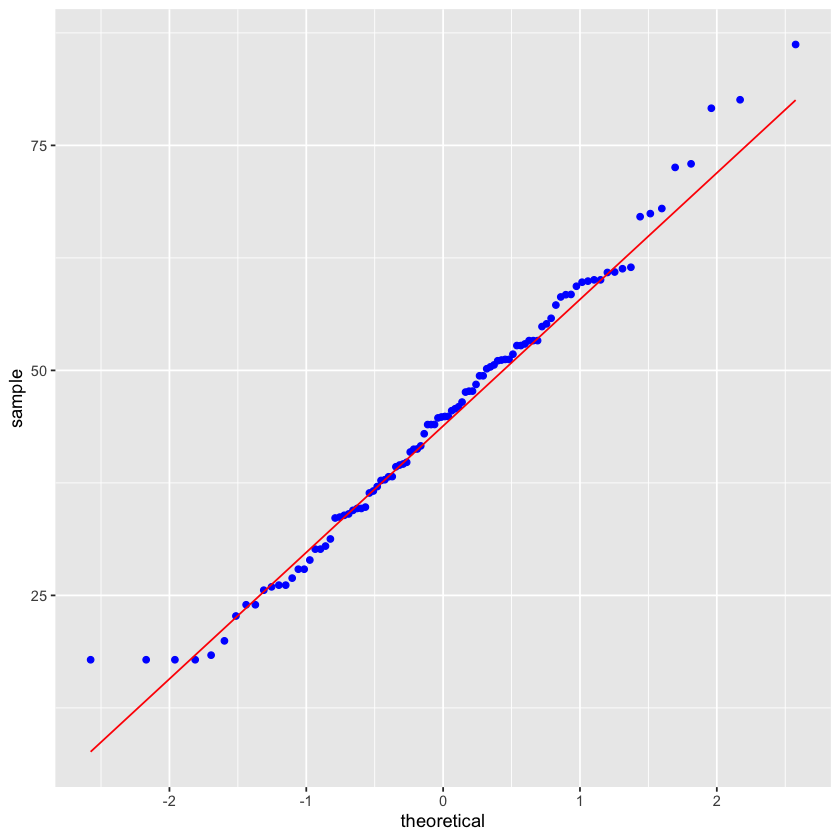

In [11]:
ggplot(sea_wage_sample, aes(sample=`Hourly Rate`))+
  stat_qq(color="blue")+stat_qq_line(color="red")

Since this blue data points so closely align with red line, it looks as though our sample data is approximately normal. In the absence of having population data, this provide evidence that our population data will also be normally distributed. Assuming normality, our confidence interval would be 

$$
\overline{x}\pm z^*\frac{s}{\sqrt{n}}
$$


Let's construct a 99% confidence interval. In this case our bound is 

In [13]:
b<-qnorm(.995)*sd(sea_wage_sample$`Hourly Rate`)/sqrt(100)
b

[1] 3.812055

*Note that I used qnorm(.995) because by default qnorm gives a lower-tailed answer rather than a two sided answer.* So This means that we have 99% confidence that our population mean is between $44.66-3.81=40.85$ and $44.66+3.81=48.47$

Let's check this (in real life we would most likely not be able to do this)

In [15]:
pop_mean<-mean(sea_wage$`Hourly Rate`)
pop_mean

[1] 46.68098

Look at that, our population mean is in fact within our confidence interval. 

### Small Sample and t-Distribution

Suppose now we had a smaller sample, let's say of 10 employees. 

In [8]:
sea_wage_sample_small<-sample_n(sea_wage,10,replace=FALSE)

Our mean of this sample is

In [18]:
small_sample_mean<-mean(sea_wage_sample_small$`Hourly Rate`)
small_sample_mean

[1] 42.7094

In this case we will need to use the $t$-distrbution with $df=9$ (remember that our data is fairly normal). Our confidence interval becomes

$$
\overline{x}\pm t^*\frac{s}{\sqrt{n}}
$$

and our bound is 

In [19]:
b_small<-qt(.995,df=9)*sd(sea_wage_sample_small$`Hourly Rate`)/sqrt(10)
b_small

[1] 17.11432

Thus our population mean is between $42.71-17.11=25.6$ and $42.71+17.11=59.82$. We know that our population mean is 46.68 and so again our population mean is within our confidence interval. However, this might not always be the case. 

### Confidence Intervals Conceptually

Remember that a confidence interval is an interval such that if one was to make repeated samples and find repeated confidence intervals, then p% of those interval would contain the parameter. 

We can check this with our City of Seattle Wage data.

In [26]:
means <-c()
bounds<-c()
check<-c()

for (i in 1:100){
  sample<-sample_n(sea_wage,100,replace=FALSE) #rexp(20,2)
  m<-mean(sample$`Hourly Rate`)
  means<-c(means,m)
  b<-qnorm(.995)*sd(sample$`Hourly Rate`)/sqrt(100)
  bounds<-c(bounds,b)
  check<-c(check,isTRUE((m-b<pop_mean) && (pop_mean<m+b)))
}
CI_example<-data.frame(means,bounds,check)

Here is a data frame of the means and bounds at 99% confidence of 100 samples of size 100. 

We expect there to be about 1 sample for which the population mean is outside the confidendce interval (this is because we made a 99% confidence interval). Let's check this.

In [27]:
filter(CI_example,check==FALSE)

means,bounds,check
<dbl>,<dbl>,<lgl>
49.82703,3.117278,FALSE


Indeed, there is only one sample for which the population mean is not contained within the calculated confidence interval.

If we use a smaller sample then we will see more variance in the mean

In [43]:
tmeans <-c()
tbounds<-c()
tcheck<-c()

for (i in 1:100){
  tsample<-sample_n(sea_wage,10,replace=FALSE)
  tm<-mean(tsample$`Hourly Rate`)
  tmeans<-c(tmeans,tm)
  tb<-qt(.995,9)*sd(tsample$`Hourly Rate`)/sqrt(10)
  tbounds<-c(tbounds,tb)
  tcheck<-c(tcheck,isTRUE((tm-tb<pop_mean) && (pop_mean<tm+tb)))
}
CI_texample<-data.frame(tmeans,tbounds,tcheck)

We can see this variance by looking at the box plots of both of the sample means

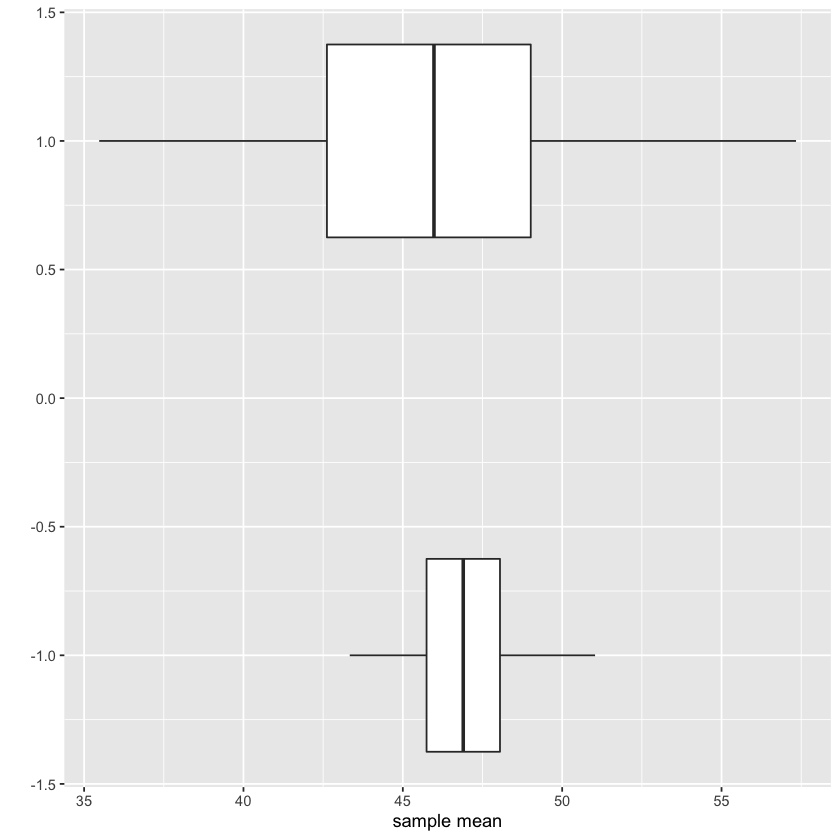

In [44]:
means_comp<-data.frame(largeSample=CI_example$means,
           smallSample=CI_texample$tmeans)
ggplot(means_comp)+
    geom_boxplot(aes(x=largeSample,y=-1))+
    geom_boxplot(aes(x=smallSample,y=1))+
    xlab("sample mean")+
    ylab("")

Looking at the box plot on the top associated to the small sample size, we see that the interquartile range is much larger than the box plot at the bottom associated with the larger sample size. This tells us that there is much more variance in the sample mean for a sample of size 10 compared to that of one of size 100.

However, if we check our confidence interval for the small samples we should still only see one interval that fails out of the 100 samples.

In [45]:
filter(CI_texample,tcheck==FALSE)

tmeans,tbounds,tcheck
<dbl>,<dbl>,<lgl>
35.473,10.21776,FALSE


In this case, out of the 100 samples, we only have one for which the population mean is not contained in the confidence interval. 

We may ask what's the benefit of taking a large sample then if we can still construct the confidence interval for smaller samples? The benefit is precision. With larger samples we can construct confidence intervals that are much smaller and therefore much more precise. 

We can verify this by looking at the average size of our bounds in the two cases

In [46]:
mean(CI_example$bounds)

[1] 3.959233

In [48]:
mean(CI_texample$tbounds)

[1] 15.28504

The confidence intervals for the smaller sample are about 3 times larger on average.

## Bootstrapping

Let's return to our 10 employee sample but this time let's use bootstrapping to create the confidence interval rather than the $t$-distribution. 

Boostrapping is a statistical method that uses resampling to approximate the samping distribution. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods

The first thing we need to do is use our 10 employee data set to create 1000 new samples and then calculate the mean of each of these samples.

In [9]:
bootmeans <-c()

for (i in 1:1000){
  bootsamp<-sample_n(sea_wage_sample_small,10,replace=TRUE)
  bootmeans<-c(bootmeans,mean(bootsamp$`Hourly Rate`))
    }

Now in order to find out what our confidence interval is we need to look at the percentiles of this new set of means. If we want a 95% confidence interval then we need the 2.5% and 97.5% percentiles. 

In [10]:
quantile(bootmeans,c(.025,.975))
boot_CI<-quantile(bootmeans,c(.025,.975))

2.5%    97.5% 
35.60258 52.86725

This means that using the bootstrap method our confidence interval is $(35.60,52.87)$

The benefit of using bootstrapping is that we do not need to know that the original population distribution is normal. Therefore, regardless of the population distribution we can use bootstrapping to find a confidence interval even for small samples. 